In [54]:
import struct
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit
from scipy import signal
import scipy.ndimage as ndimage

DATA_TYPES = {'short':(2,'h'),'short-data':(2,'h'), 'unsignedshort':(2,'H'),
              'integer-data':(4,'i'), 'signedinteger':(4,'i'),
              'float-data':(4,'f'), 'double':(8,'d')}

def wsxm_get_common_files(filepath):
    # filepath = 'data/interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi'
    path_dir = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    # filename_com = os.path.basename(filepath).split('.')[0] #common file name
    match = re.search(r'\d{4}', filename) #regex to find 4 digit number in filename
    filename_com = filename[:match.start()+4]
    # print(filename_com)
    files = []
    for i in os.listdir(path_dir):
        path_i = os.path.join(path_dir,i)
        if os.path.isfile(path_i) and i.startswith(filename_com):
            files.append(path_i)    
    
    return files


#read WSxM header data
def wsxm_readheader(file, pos=0, inibyte=100):
    header_dict = {}
    # Find header size
    file.seek(pos, 0)
    data = file.read(inibyte)
    for ln in data.splitlines():
        hd_lst = ln.decode('ascii', errors='ignore').split(':')
        if len(hd_lst) == 2:
            if hd_lst[0] == 'Image header size':
                header_size = int(hd_lst[1])
                # print(header_size)
                break
    # read header data
    file.seek(pos, 0)
    data = file.read(header_size)#[:header_size]
    for ln in data.splitlines():
        hd_lst = ln.decode('ascii', errors='ignore').split(':')
        if len(hd_lst) == 2:
            header_dict[hd_lst[0].strip()] = hd_lst[1].strip()
    
    pos_new = pos + header_size #bytes read so far
    # print(header_dict)
    return header_dict, pos_new

#read WSxM binary image data
def wsxm_readimg(file, header_dict, pos):
    data_format = header_dict['Image Data Type']
    chan_label = header_dict['Acquisition channel']
    line_rate = float(header_dict['X-Frequency'].split(' ')[0])
    x_num = int(header_dict['Number of rows'])
    y_num = int(header_dict['Number of columns'])
    x_len = float(header_dict['X Amplitude'].split(' ')[0])
    y_len = float(header_dict['Y Amplitude'].split(' ')[0])
    z_len = float(header_dict['Z Amplitude'].split(' ')[0])
    x_dir = header_dict['X scanning direction']
    y_dir = header_dict['Y scanning direction'] #CHECK Y DIRECTIONS

    x_data = np.linspace(0, x_len, x_num, endpoint=True) if x_dir == 'Backward' else np.linspace(x_len, 0, x_num, endpoint=True)
    y_data = np.linspace(0, y_len, y_num, endpoint=True) if y_dir == 'Down' else np.linspace(y_len, 0, y_num, endpoint=True)
    xx_data, yy_data = np.meshgrid(x_data, y_data)
    
    #read binary image data
    point_length, type_code  = DATA_TYPES[data_format]
    # with open(filepath, 'rb') as file:
    file.seek(pos, 0)
    data_len = x_num*y_num*point_length
    bin_data = file.read(data_len)
    # print(data.read()[(x_num*y_num*point_length)+header_size:])
    ch_array = np.array(list(struct.iter_unpack(f'{type_code}', bin_data))).flatten()
    z_calib = z_len/(ch_array.max()-ch_array.min())
    #img data dictionary
    data_dict_chan = {'data': {'Z': z_calib*ch_array,
                               'X': xx_data.flatten(),
                               'Y':yy_data.flatten(),},
                      'header': header_dict}
    
    pos += data_len #bytes read so far
    return data_dict_chan, pos
    
# Read WSxM channel image data
def wsxm_readchan(filepath):
    file = open(f'{filepath}','rb')
    header_dict, pos = wsxm_readheader(file)
    data_dict_chan, pos = wsxm_readimg(file, header_dict, pos)    
    data_dict = {header_dict['X scanning direction']: data_dict_chan}
    return data_dict

# read *.curves file with image and f-d curves
#TODO: read other spectro data (*.stp and *.cur) similarly and output it in the same format as data_dict below!
#TODO: apply Conversion Factor to final channel value. CHECK THIS EVERYWHERE!
def wsxm_readcurves(filepath):
    filepath_all = wsxm_get_common_files(filepath)
    data_dict = {}
    for path in filepath_all:
        path_ext = os.path.splitext(path)[1] #file extension
        if path_ext == '.curves': # read *.curves spectroscopy files
            file = open(f'{path}','rb')
            header_dict, pos = wsxm_readheader(file)
            data_dict_chan, pos = wsxm_readimg(file, header_dict, pos) 
            
            data_format = header_dict['Image Data Type']
            point_length, type_code  = DATA_TYPES[data_format]
            data_dict_curv = {}
            
            while True:
                # file.seek(pos, 0)
                header_dict, pos = wsxm_readheader(file, pos=pos)     
                line_pts = int(header_dict['Number of points'])
                line_num = int(header_dict['Number of lines'])
                y_label = header_dict['Y axis text'].split('[')[0].strip()
                x_label = header_dict['X axis text'].split('[')[0].strip()
                curv_ind = int(header_dict['Index of this Curve'])
                curv_num = int(header_dict['Number of Curves in this serie'])
                aqpt_x, aqpt_y = tuple(map(float, header_dict['Acquisition point'].replace('nm','').
                                           replace('(','').replace(')','').split(',')))
                time_f = float(header_dict['Forward plot total time'].split(' ')[0])
                time_b = float(header_dict['Backward plot total time'].split(' ')[0])
                
                line_order = ['approach', 'retract']
                if header_dict['First Forward'] == 'No': #CHECK THIS
                    line_order = ['retract', 'approach']
        
                data_len = line_pts*line_num*2*point_length
                file.seek(pos, 0)
                bin_data = file.read(data_len)
                ch_array = np.array(list(struct.iter_unpack(f'{type_code}', bin_data))).flatten()
                
                data_dict_curv[curv_ind] = {'data': {'x': ch_array[::2],
                                                     'y': ch_array[1::2],
                                                     'segment':np.append(line_pts * [line_order[0]],line_pts * [line_order[1]])},
                                            'header': header_dict
                                            }
                
                if curv_ind == curv_num:
                    break
                else:
                    pos += data_len #bytes read so far
                    file.seek(pos, 0)
        
            data_dict[y_label] = {'Channel': data_dict_chan,
                                  'Curves': data_dict_curv
                                  }
    
    return data_dict

# Read WSxM Force volume data
def wsxm_readforcevol(filepath):
    filepath_all = wsxm_get_common_files(filepath)
    data_dict = {}
    for path in filepath_all:
        path_ext = os.path.splitext(path)[1] #file extension
        # if path_ext == '.top': #topgraphy data
        #     data_dict['Topography'] = wsxm_readchan(path)
        if path_ext == '.gsi': #force volume data from *.gsi files
            file = open(f'{path}','rb')
            header_dict, pos = wsxm_readheader(file)
            
            data_format = header_dict['Image Data Type']
            chan_label = header_dict['Acquisition channel']
            spec_dir = header_dict['Spectroscopy type']
            x_dir = spec_dir.split(' ')[1]
            y_dir = header_dict['Y scanning direction'] #CHECK Y DIRECTIONS
            line_rate = float(header_dict['X-Frequency'].split(' ')[0])
            x_num = int(header_dict['Number of rows'])
            y_num = int(header_dict['Number of columns'])
            chan_num = int(header_dict['Number of points per ramp'])
            x_len = float(header_dict['X Amplitude'].split(' ')[0])
            y_len = float(header_dict['Y Amplitude'].split(' ')[0])
            z_len = float(header_dict['Z Amplitude'].split(' ')[0])
            chan_adc2v = float(header_dict['ADC to V conversion factor'].split(' ')[0])
            chan_fact = float(header_dict['Conversion factor 0 for input channel'].split(' ')[0])
            chan_offs = float(header_dict['Conversion offset 0 for input channel'].split(' ')[0])
            
        
            x_data = np.linspace(0, x_len, x_num, endpoint=True) if x_dir == 'Backward' else np.linspace(x_len, 0, x_num, endpoint=True)
            y_data = np.linspace(0, y_len, y_num, endpoint=True) if y_dir == 'Up' else np.linspace(y_len, 0, y_num, endpoint=True)
            xx_data, yy_data = np.meshgrid(x_data, y_data)
        
            z_data = np.empty(0)
            for i in range(chan_num):
                z_data = np.append(z_data, float(header_dict[f'Image {i:03}'].split(' ')[0]))
            z_data = np.flip(z_data) #reverse z data order to make zero as point of contact
            
            #read binary image data
            point_length, type_code  = DATA_TYPES[data_format]
            # with open(filepath, 'rb') as file:
            file.seek(pos, 0)
            data_len = x_num*y_num*point_length
            # pos += data_len #skip first topo image
            #read first topography data
            bin_data = file.read(data_len)
            topo_array = np.array(list(struct.iter_unpack(f'{type_code}', bin_data))).flatten()
            topo_calib = z_len/(topo_array.max()-topo_array.min())
            #topo data dictionary
            data_dict_topo = {'data': {'Z': topo_calib*topo_array,
                                       'X': xx_data.flatten(),
                                       'Y': yy_data.flatten()
                                       },
                              'header': header_dict}
            topo_label = 'Topography'
            if topo_label not in data_dict.keys():
                data_dict[topo_label] = {}
            data_dict[topo_label][spec_dir] = data_dict_topo
            
            pos += data_len
            ch_array = np.empty(0) #initialize channel data array
            for i in range(1, chan_num+1):
                file.seek(pos, 0)
                bin_data = file.read(data_len)
                # print(data.read()[(x_num*y_num*point_length)+header_size:])
                ch_array_temp = np.array(list(struct.iter_unpack(f'{type_code}', bin_data))).flatten()
                # print(ch_array_temp.min(), ch_array_temp.max())
                # if i == 0:
                #     z_calib = z_len/(ch_array_temp.max()-ch_array_temp.min())
                # else:
                ch_array = np.append(ch_array, chan_offs+(ch_array_temp*chan_adc2v*chan_fact))
                pos += data_len #next image
            # print(z_calib, chan_adc2v, z_len)
            
            #img data dictionary
            data_dict_chan = {'data': {'ZZ': ch_array.reshape(x_num,y_num,chan_num),
                                       'X': xx_data.flatten(),
                                       'Y': yy_data.flatten(),
                                       'Z': z_data
                                      },
                              'header': header_dict}
            if chan_label not in data_dict.keys():
                data_dict[chan_label] = {}
            data_dict[chan_label][spec_dir] = data_dict_chan
        
        # pos += data_len #bytes read so far    
    return data_dict

In [62]:
def func_adhesion(force_data, zero_pts):
    f_zero = force_data['approach']['y'][:zero_pts].mean()
    f_min = force_data['retract']['y'].min()
    return f_zero - f_min, {'zero': f_zero, 'min': f_min}

def func_snapin(defl_data):
    defl_sobel = ndimage.sobel(defl_data['approach']['y']) #sobel transform
    idx_min = np.argmin(defl_sobel) #id of sharpest corner in defl data
    defl_snapin = defl_data['approach']['y'][idx_min]
    z_snapin = defl_data['approach']['x'][idx_min]
    defl_idx_min = np.argmin(defl_data['approach']['y'])
    defl_min = defl_data['approach']['y'][defl_idx_min]
    # z_min = defl_data['approach']['x'][defl_idx_min]
    # print(idx_min)
    return defl_snapin - defl_min, {'x': [z_snapin, z_snapin], 'y': [defl_snapin, defl_min]}

def func_stiffness(force_data, bad_pts):
    segment = 'approach'
    idx_min = np.argmin(force_data[segment]['y'])
    if idx_min == force_data[segment]['x'].shape[0]-1: #when spectra not good
        return np.inf, {'x': force_data[segment]['x'][idx_min:], 'y': force_data[segment]['y'][idx_min:]}
    else:
        p, res, rank, sing, rcond = np.polyfit(force_data[segment]['x'][idx_min:], 
                                               force_data[segment]['y'][idx_min:], 1, full=True)
        poly = np.poly1d(p)
        fit_data = {'x': force_data[segment]['x'][idx_min:], 'y': poly(force_data[segment]['x'][idx_min:])}
    return -p[0], fit_data

#TODO: calibration dictionary to get in nm or nN from volts

#dictionary of functions defined to extract spectroscopy data properties
# FUNC_DICT = {'Adhesion': {'function':func_adhesion,
#                           'channel': 'Normal force',
#                           'kwargs': {'zero_pts': 10
#                                     }
#                          },
#              'Stiffness': {'function':func_stiffness,
#                            'channel': 'Normal force',
#                            'kwargs': {'bad_pts':1}
#                            },
#              'Snap-in distance': {'function':func_snapin,
#                                   'channel': 'Normal force',
#                                   'kwargs': {}
#                                   },
#              }

FUNC_DICT = {'Normal force': {'Adhesion': {'function':func_adhesion,
                                           'kwargs': {'zero_pts': 10}
                                           },
                              'Stiffness': {'function':func_stiffness,
                                            'kwargs': {'bad_pts':1}
                                            },
                              'Snap-in distance': {'function':func_snapin,
                                                   'kwargs': {}
                                                   }
                              },
             'Amplitude': {},
             'Excitation frequency': {},
             'Phase': {}
            }

#rename spectroscopy line to standard names: approach and retract
SPECT_DICT = {'Forward':'approach', 'Backward': 'retract'} 

# Get spectroscopy data from force volume
def wsxm_getspectro1(data, channel, img_dir, x, y, segment='both'):
    # label_dict = {'Forward':'approach', 'Backward': 'retract'} #rename lines
    #initialize spectroscopy data dictionary
    data_fd_dict = {'x': np.empty(0), 'y': np.empty(0), 'segment': np.empty(0)}
    #spectroscopy keys for the same image direction
    img_keys = [key for key in data[channel].keys() if key.startswith(f'Image {img_dir}')] 
    spectro_data = {}
    for key in img_keys:
        spectro_dir = SPECT_DICT[key.split(' ')[3]]
        if segment != 'both' and segment != spectro_dir: #skip unwanted segment
            continue
        line_pts = int(data[channel][key]['header']['Number of points per ramp'])
        data_fd_dict['x'] = np.append(data_fd_dict['x'], data[channel][key]['data']['Z'])
        data_fd_dict['y'] = np.append(data_fd_dict['y'], data[channel][key]['data']['ZZ'][:,y,x])
        data_fd_dict['segment'] = np.append(data_fd_dict['segment'], line_pts*[spectro_dir])
        spectro_data[spectro_dir] = {'y': data[channel][key]['data']['ZZ'][:,y,x],
                                     'x': data[channel][key]['data']['Z']}
    data_fd = pd.DataFrame.from_dict(data_fd_dict)
    #perform calculations for parameters (e.g. adhesion, stiffness, check FUNC_DICT) on the single spectroscopy curve
    data_dict_param = {}
    # for param in params:
    #     if channel == FUNC_DICT[param]['channel']:
    #         kwargs = FUNC_DICT[param]['kwargs']
    #         _, data_dict_param[param] = FUNC_DICT[param]['function'](spectro_data, **kwargs)
    for param in FUNC_DICT[channel].keys():
        kwargs = FUNC_DICT[channel][param]['kwargs']
        _, data_dict_param[param] = FUNC_DICT[channel][param]['function'](spectro_data, **kwargs)   
        
    # print(x,y,data['ZZ'])
    return data_fd, data_dict_param

# Get spectroscopy data from separate force-distance measurement (*.curves)
def wsxm_getspectro2(data, channel, curv_num):
    #perform calculations for parameters (e.g. adhesion, stiffness, check FUNC_DICT) on the single spectroscopy curve
    data_fd_dict = data[channel]['Curves'][curv_num]['data']
    data_fd = pd.DataFrame.from_dict(data_fd_dict) #for plotting
    spectro_data = {} #for function analysis
    for t in data_fd['segment'].unique():
        spectro_data[t] = {'x': data_fd[data_fd['segment']==t]['x'].to_numpy(),
                           'y': data_fd[data_fd['segment']==t]['y'].to_numpy()}
    data_dict_param = {}
    params = FUNC_DICT[channel].keys()
    for param in params:
        if channel == FUNC_DICT[param]['channel']:
            kwargs = FUNC_DICT[param]['kwargs']
            _, data_dict_param[param] = FUNC_DICT[param]['function'](spectro_data, **kwargs)
        
    return data_fd, data_dict_param
    
#obtain property image from spectroscopy data of force-volume based on functions defined in FUNC_DICT
def calc_spectro_prop(data, channel, img_dir):
    # img_keys = [key for key in data[channel].keys() if key.startswith(f'Image {img_dir}')] 
    data_dict_spectro = {}
    params = FUNC_DICT[channel].keys()
    for param in params:
        data_dict_spectro[param] = np.empty(0)
    #get common data from first channel e.g. number of points
    # channel = FUNC_DICT[params[0]]['channel']
    key = list(data[channel].keys())[0]
    x_pts = int(data[channel][key]['header']['Number of rows'])
    y_pts = int(data[channel][key]['header']['Number of columns'])
    for y in range(y_pts):
        for x in range(x_pts):
            for param in params:
                # channel = FUNC_DICT[channel][param]['channel']
                kwargs = FUNC_DICT[channel][param]['kwargs']
                img_keys = [key for key in data[channel].keys() if key.startswith(f'Image {img_dir}')]
                spectro_data = {}
                for key in img_keys:
                    spectro_dir = SPECT_DICT[key.split(' ')[3]]
                    spectro_data[spectro_dir] = {'y': data[channel][key]['data']['ZZ'][:,y,x],
                                                 'x': data[channel][key]['data']['Z']}
                param_result,_ = FUNC_DICT[channel][param]['function'](spectro_data, **kwargs)
                data_dict_spectro[param] = np.append(data_dict_spectro[param], [param_result])
    # data_dict_spectro[spectro_dir] = adh_data.reshape(x_pts,y_pts)
        
    return data_dict_spectro


In [3]:
#Load WSxM file
#filepath = 'data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15'
#filepath = 'data/interdigThiols_tipSi3nN_b_0026.f.dy.top'
filepath = 'data/interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi' #ff,fb,bb,bf:1st letter=x dir,2nd letter=z dir
#filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'

data_dict = wsxm_readforcevol(filepath) #complete force volume data with all channels

In [64]:
filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'
test_data = wsxm_readcurves(filepath)
print(test_data.keys())
calc_curve_prop(test_data, 'Excitation frequency', 1)

dict_keys(['Excitation frequency', 'Phase'])


(               x         y   segment
 0      -0.000000  0.058899  approach
 1       0.391389  0.039368  approach
 2       0.782779  0.047913  approach
 3       1.174168  0.053711  approach
 4       1.565558  0.060120  approach
 ...          ...       ...       ...
 1019  198.434448  0.893860   retract
 1020  198.825836  0.881958   retract
 1021  199.217224  0.877380   retract
 1022  199.608612  0.878296   retract
 1023  200.000000  0.867920   retract
 
 [1024 rows x 3 columns],
 {})

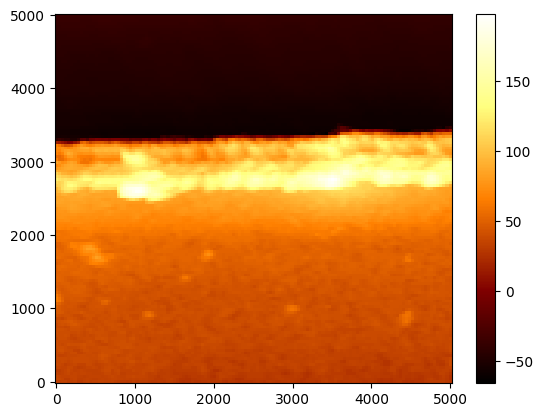

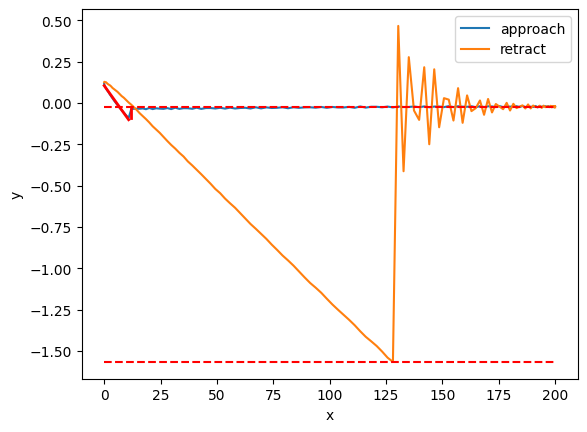

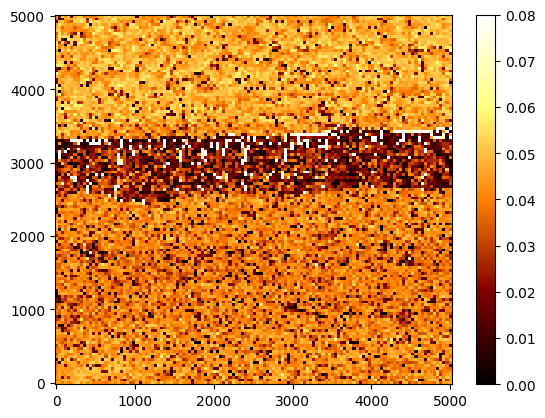

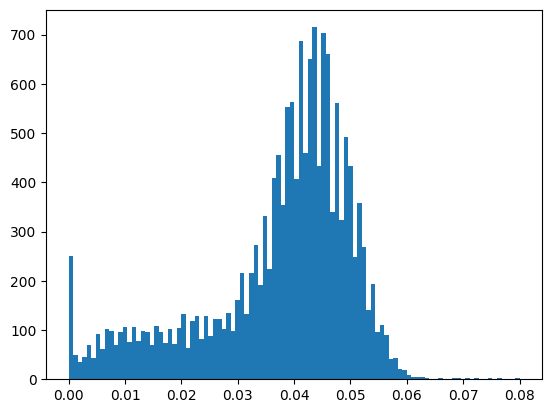

In [7]:
channel = 'Topography' #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
chan_dir = 'Image Forward with Forward Ramps' #'Image Forward with Forward Ramps', 'Image Backward with Backward Ramps', 'Image Backward with Forward Ramps', 'Image Forward with Backward Ramps'
img_dir = chan_dir.split(' ')[1]
data_dict_chan = data_dict[channel][chan_dir]
im_data = data_dict_chan['data']
header_dict = data_dict_chan['header']

# data_dict = wsxm_readchan(filepath)
# im_data = data_dict['data']

# test_data = wsxm_readcurves(filepath)
#plot AFM Z image
# im_data = test_data['Channel']['data']
xx = im_data['X'].reshape(128,128)
yy = im_data['Y'].reshape(128,128)
zz = im_data['Z'].reshape(128,128)
# zz = im_data['ZZ'][127,:,:]#1st index:xy sections, 2nd index:xz sections, 3rd index: yz sections

#TODO: change and check how forward backward in z (or x) can be consistently plotted
# print(zz.min(),zz.max(), zz.max()-zz.min())

plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()

# if header_dict['Spectroscopy direction'] == 'Forward': #CHECK THIS
#     segment
#obtain and plot spectroscopy data
chan_spectro = 'Normal force'
# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
#CHECK x and y in all functions!!!
data_spectro, data_param = wsxm_getspectro(data_dict, channel=chan_spectro, img_dir=img_dir,
                                           x=1, y=120, segment='both')
# print(fd)
fig, ax = plt.subplots()
sns.lineplot(data=data_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
plt.hlines(data_param['Adhesion']['zero'], data_spectro['x'].min(), 
           data_spectro['x'].max(), linestyles='dashed', colors='r')
plt.hlines(data_param['Adhesion']['min'], data_spectro['x'].min(), 
           data_spectro['x'].max(), linestyles='dashed', colors='r')
plt.plot(data_param['Snap-in distance']['x'], data_param['Snap-in distance']['y'],
         'r', linestyle='solid',linewidth=2)
plt.plot(data_param['Stiffness']['x'], data_param['Stiffness']['y'],
         'r', linestyle='solid',linewidth=2)
# acq_pt = test_data['Curves'][3]['header']['Acquisition point'].strip('()').split(',')
# plt.scatter(float(acq_pt[0]), float(acq_pt[1]),color = 'green')
plt.show()
# header_dict
# #plot Curves
# test_df = pd.DataFrame.from_dict(test_data['Curves'][3]['data'])
# sns.lineplot(data=test_df, x="Z", y="Excitation frequency", hue="Segment")
# plt.show()

# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
img_specparams = calc_spectro_prop(data_dict, chan_spectro, img_dir)
img_adh = img_specparams['Snap-in distance']
plt.pcolormesh(xx,yy,img_adh.reshape(128,128), cmap='afmhot',vmin=None, vmax=0.08)
plt.colorbar()
plt.figure()
plt.hist(img_adh, bins=100, range=(0,0.08))
plt.show()

In [121]:
def get_psd(filepath):
    im_data, head_data = read_wsxm_chan(filepath)
    print(head_data)
    #plot AFM Z image
    xx = im_data['X'].reshape(128,128)
    yy = im_data['Y'].reshape(128,128)
    zz = im_data['Z'].reshape(128,128)
    plt.pcolormesh(xx,yy,zz, cmap='afmhot')
    plt.colorbar()
    plt.show()
    
    #Obtain Power Spectral Density of data
    #sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
    sample_rate = float(head_data['Sampling frequency'].split(' ')[0])
    freq_array, z_pow = signal.periodogram(zz, sample_rate, scaling='density') #power spectral density
    z_pow_avg = np.average(z_pow, axis=0) #averaged
    freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
    freq_array_shifted = freq_array + freq_drive
    # plt.plot(freq_array, z_pow_avg)
    # plt.show()

    z = im_data['Z']
    z_rms = np.sqrt(z.dot(z)/z.size)
    
    return freq_array_shifted, z_pow_avg, z_rms


#Lorentzian fit
# y0 = white noise offset, f0 = resonance freq, w = Full width at half maximum, A = area
def lorentzian(f, y0,f0, w, A):
    return y0 + ((2*A/np.pi) * (w / ( w**2 + 4*( f - f0 )**2)))

{'Image header size': '3031', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

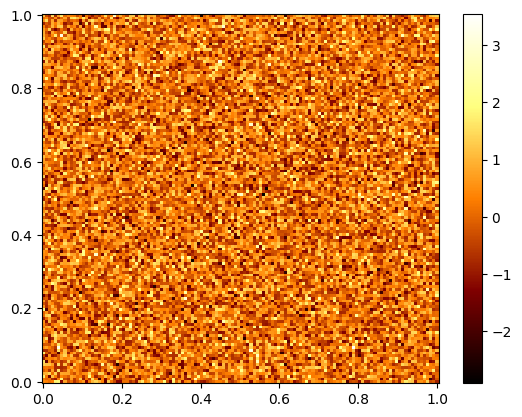

{'Image header size': '3037', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

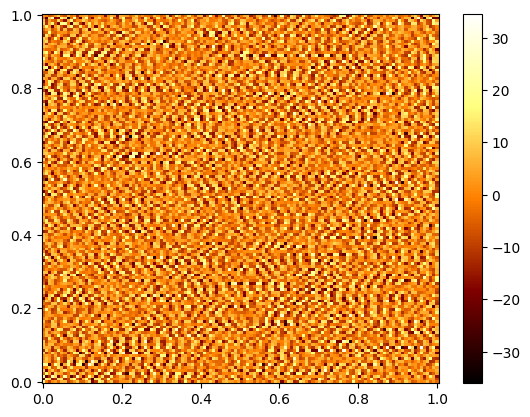

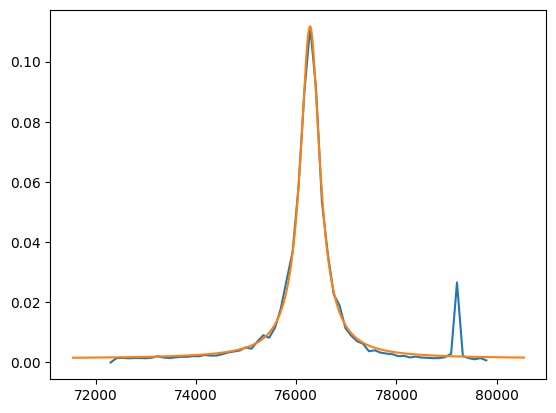

{'offset': 0.0012934139192533319, 'resonance freq': 76274.15433510602, 'fwhm': 473.8767061692985, 'area': 82.11451304229297, 'Q factor': 160.9578047245397}


In [2]:
files = ['data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15', 
         'data/20240202_laser_on_128pts_58lps_0003.f.dy.ch15']
data_dict = {}
rms_min = np.inf
for file in files:
    data_dict[file] = {}
    data_dict[file]['Frequency'], data_dict[file]['PSD'], data_dict[file]['Z rms'] = get_psd(file)
    if data_dict[file]['Z rms'] < rms_min:
        rms_min = data_dict[file]['Z rms']
        off_file = file

on_file = [n for n in files if n != off_file][0]
data_dict[off_file]['Label'] = 'Laser ON'
data_dict[on_file]['Label'] = 'Laser OFF'

#plot data images
# for file in files:
#     plt.plot(data_dict[file]['Frequency'], data_dict[file]['PSD'], label = data_dict[file]['PSD'])
# plt.show()
    

#z_pow = 2*(z_fftx_avg[64:]**2)/(15000*128)
#freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
#freq_array_real = freq_array_shift[64:] + freq_drive
freq_final = data_dict[on_file]['Frequency']
psd_final = data_dict[on_file]['PSD'] - data_dict[off_file]['PSD']
plt.plot(freq_final, psd_final)
#plt.show()

#guess = [0, 76000, 2000, 100000]
y_guess = psd_final.min()
f_guess = freq_final[psd_final.argmax()]
w_guess = 2*np.abs(freq_final[(np.abs(psd_final - psd_final.max()/2)).argmin()]-f_guess)
A_guess = np.pi*w_guess*psd_final.max()/2
guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
#fit
popt, pcov = curve_fit(lorentzian, freq_final,psd_final,
                    p0=guess, bounds=(0,np.inf))
#print(np.linalg.cond(pcov))
params = ['offset','resonance freq', 'fwhm', 'area']
fit_dict = dict(zip(params, popt))
fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']

#plot fit
f_min, f_max = freq_final.min(), freq_final.max()
f_ext = 0.1*(f_max-f_min)
freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
plt.plot(freq_fit_range,lorentzian(freq_fit_range, *popt))
plt.show()

print(fit_dict)

In [37]:
# Q = head_data['Quality factor (Q)']
k_cant = 2 # N/m
T = 300 #K
kb = 1.380649e-23 #J/K
V_rms = np.sqrt(fit_dict['area'])
corr_fac = 4/3 #Butt-Jaschke correction for thermal noise
sens = np.sqrt(corr_fac*kb*T/k_cant)/V_rms/1e-9 #nm/V 
print(V_rms, sens)
print(np.sqrt(data_dict[on_file]['Z rms']**2 - data_dict[off_file]['Z rms']**2))
# z = im_data['Z']
# print(np.sqrt(z.dot(z)/z.size))

9.061705857193388 0.005798914136715741
9.421556156513725


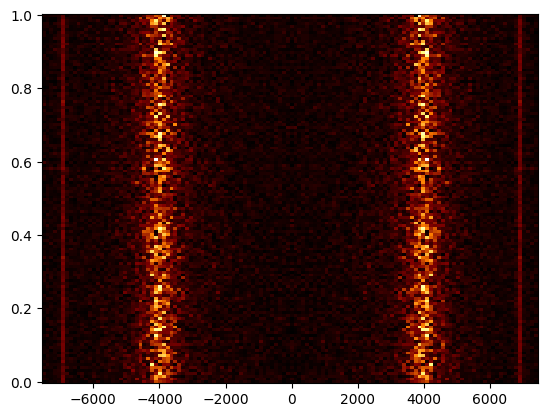

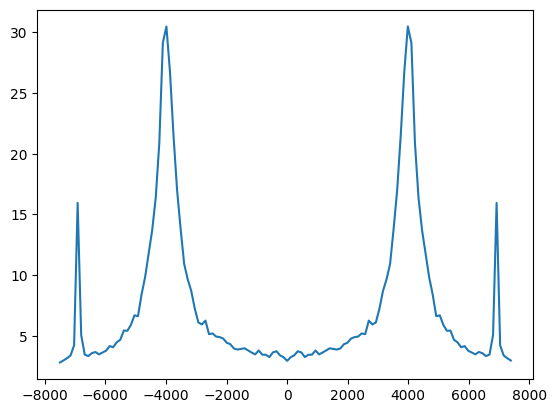

In [6]:
# #1D Fourier Transform of image and average along Y axis.
# z_fftx = np.abs(np.fft.fft(zz))
# z_fftx_shift = np.fft.fftshift(z_fftx)
# z_fftx_avg = np.average(z_fftx_shift, axis=0)

# num_pts = len(z_fftx_avg)
# sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
# freq_array = np.fft.fftfreq(len(z_fftx_avg), 1 / sample_rate)
# freq_array_shift = np.fft.fftshift(freq_array)
# ff, _ = np.meshgrid(freq_array_shift, freq_array_shift)
# plt.pcolormesh(ff, yy, z_fftx_shift, cmap='afmhot')
# plt.show()
# plt.plot(freq_array_shift, z_fftx_avg)
# plt.show()